## Loading libraries and data

In [3]:
import sys
import os
import gc

sys.path.append("../src")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import cufflinks as cf

cf.go_offline()

import pmdarima as pm
from hts import HTSRegressor

from visualize import get_nodes_edges_position, make_annotations

In [4]:
df_hier_sales = pd.read_csv("../data/preprocessed/M5_hierarchical_data.csv")
df_hier_sales.head(4)

,total,state_id,store_id,cat_id,dept_id,2011-01-29,2011-01-30,2011-01-31,2011-02-01,2011-02-02,...,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
0,Total,CA,CA_1,FOODS,FOODS_1,297,284,214,175,182,...,293,317,268,302,237,287,297,331,419,329
1,Total,CA,CA_1,FOODS,FOODS_2,674,655,396,476,354,...,435,499,637,529,391,423,365,489,590,734
2,Total,CA,CA_1,FOODS,FOODS_3,2268,2198,1398,1607,1496,...,1978,2665,3099,2055,1860,1780,1871,2140,2646,2990
3,Total,CA,CA_1,HOBBIES,HOBBIES_1,528,489,409,383,263,...,370,690,597,517,461,333,380,471,621,641


### Minimal Dataprep and Filtering

Let's melt our data so we have our data represented in tidy format as well as removing day 25-12 where I know apriori that majority of stores were closed due to Walmart's policy. Regarding other components of data preparation, I left to a minimal level here, any issue will be treated in *hierarchical-data-definition* and then here we will always get most recent data for modelling.

In [5]:
df_hier = (
  df_hier_sales.melt(id_vars=["total", "dept_id", "store_id", "state_id", "cat_id"],
                    var_name="date",
                    value_name="unit_solds")
               .assign(date=lambda df: pd.to_datetime(df['date']))
)

df_hier.head(4)

,total,dept_id,store_id,state_id,cat_id,date,unit_solds
0,Total,FOODS_1,CA_1,CA,FOODS,2011-01-29,297
1,Total,FOODS_2,CA_1,CA,FOODS,2011-01-29,674
2,Total,FOODS_3,CA_1,CA,FOODS,2011-01-29,2268
3,Total,HOBBIES_1,CA_1,CA,HOBBIES,2011-01-29,528


In [6]:
df_hier.shape

(133910, 7)

We will use scikit-hts library, so we need to transform each column in our dataset in a time series relating to a branch in our hierarchical level.

In [7]:
df_hier['id'] = df_hier.apply(lambda x: f"{x['state_id']}_{x['store_id']}_{x['cat_id']}_{x['dept_id']}", axis=1)
df_hier['store_cat_id'] = df_hier.apply(lambda x: f"{x['store_id']}_{x['cat_id']}", axis=1)
df_hier['store_cat_dept_id'] = df_hier.apply(lambda x: f"{x['store_id']}_{x['cat_id']}_{x['dept_id']}", axis=1)

In [8]:
def return_agg_by_hier(df, column):
    return df.pivot_table(index='date', columns=column, values='unit_solds', aggfunc='sum')

df_states = return_agg_by_hier(df_hier, column='state_id')
df_stores = return_agg_by_hier(df_hier, column='store_id')
df_cats = return_agg_by_hier(df_hier, column='store_cat_id')
df_depts = return_agg_by_hier(df_hier, column='store_cat_dept_id')

In [9]:
df_total = (df_states['CA'] + df_states['WI'] + df_states['TX']).to_frame(name="total")

In [10]:
df_all = pd.concat([df_total, df_states, df_stores, df_cats, df_depts], axis=1)
df_all.head(5)

,total,CA,TX,WI,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,...,WI_2_HOBBIES_HOBBIES_2,WI_2_HOUSEHOLD_HOUSEHOLD_1,WI_2_HOUSEHOLD_HOUSEHOLD_2,WI_3_FOODS_FOODS_1,WI_3_FOODS_FOODS_2,WI_3_FOODS_FOODS_3,WI_3_HOBBIES_HOBBIES_1,WI_3_HOBBIES_HOBBIES_2,WI_3_HOUSEHOLD_HOUSEHOLD_1,WI_3_HOUSEHOLD_HOUSEHOLD_2
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,32631,14195,9438,8998,4337,3494,4739,1625,2556,3852,...,10,353,98,152,583,2293,256,22,584,148
2011-01-30,31749,13805,9630,8314,4155,3046,4827,1777,2687,3937,...,7,268,94,138,585,2383,342,14,541,195
2011-01-31,23783,10108,6778,6897,2816,2121,3785,1386,1822,2731,...,18,250,69,127,575,1841,228,20,420,106
2011-02-01,25412,11047,7381,6984,3051,2324,4232,1440,2258,2954,...,15,305,80,98,533,1965,183,11,327,94
2011-02-02,19146,9925,5912,3309,2630,1942,3817,1536,1694,2492,...,1,118,32,87,340,1427,70,4,151,53


In [11]:
states = df_hier.state_id.unique()
stores = df_hier.store_id.unique()
cats = df_hier.store_cat_id.unique()
depts = df_hier.store_cat_dept_id.unique()

# Here we build the tree as a dictionary. Each node (key in dict) has a list of 
# children value in dict, which in turn may also be a key in the dict, and have 
# children as well 
total = {'total': list(states)}
state_h = {k: [v for v in stores if v.startswith(k)] for k in states}
store_h = {k: [v for v in cats if v.startswith(k)] for k in stores}
dept_h = {k: [v for v in depts if v.startswith(k)] for k in cats}

In [12]:
hierarchy = {**total, **state_h, **store_h, **dept_h}

## Endogenous variable only

### SARIMA

scikit-hts uses auto_arima function pro library pmdarima. This will be more appropriate in our case since doing all steps required to fit a SARIMA model would be tedious and take a really long time, so our best option will let to default arguments to choose best parameters and analyze results.

In [18]:
from hts import HTSRegressor
from pmdarima.model_selection import train_test_split

auto_arima_args = dict(m=7)

df_all = df_all.resample('D').sum()

train, test = train_test_split(df_all, test_size=28)
clf_hw_hier = HTSRegressor(model='holt_winters', revision_method='OLS', n_jobs=0)

model_hw = clf_hw_hier.fit(train, hierarchy)


Fitting models: 100%|██████████| 114/114 [00:00<00:00, 245.86it/s]


In [19]:
predicted_hw = clf_hw_hier.predict(steps_ahead=28)


Fitting models: 100%|██████████| 114/114 [00:00<00:00, 129.14it/s]


In [25]:
y_train = train
y_true = test
y_pred = predicted_hw[-test.shape[0]:]

In [30]:
hts.metrics

AttributeError: module 'hts' has no attribute 'metrics'

In [94]:
np.where(mean_absolute_scaled_error(y_true, y_pred, y_train, naive_period=1) < 1)

(array([24, 26, 32, 61, 68, 73, 74, 80, 82, 88]),)

In [97]:
mean_absolute_scaled_error(y_true, y_pred, y_train, naive_period=1).head(26)

total             1.615398
CA                1.615166
TX                1.285696
WI                1.523779
CA_1              1.429641
CA_2              1.726998
CA_3              1.550915
CA_4              1.263155
TX_1              1.219877
TX_2              1.315916
TX_3              1.211615
WI_1              1.782247
WI_2              1.780078
WI_3              1.486839
CA_1_FOODS        1.442081
CA_1_HOBBIES      1.006134
CA_1_HOUSEHOLD    1.440103
CA_2_FOODS        1.772898
CA_2_HOBBIES      1.156626
CA_2_HOUSEHOLD    1.490187
CA_3_FOODS        1.910895
CA_3_HOBBIES      1.136822
CA_3_HOUSEHOLD    1.413071
CA_4_FOODS        1.193782
CA_4_HOBBIES      0.865187
CA_4_HOUSEHOLD    1.621874
dtype: float64

In [76]:
mean_absolute_scaled_error(y_true['CA'], y_pred['CA'], y_train['CA'], naive_period=7)

AttributeError: 'Series' object has no attribute 'columns'

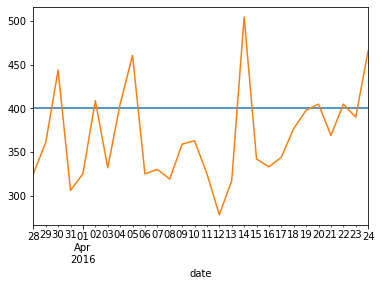

In [101]:
y_pred['CA_4_HOBBIES'].plot()
y_true['CA_4_HOBBIES'].plot()

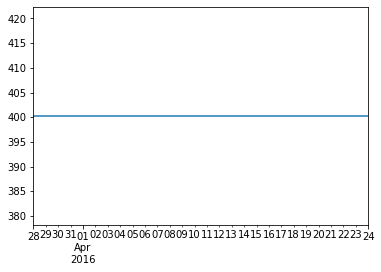

In [102]:
y_pred['CA_4_HOBBIES'].plot()

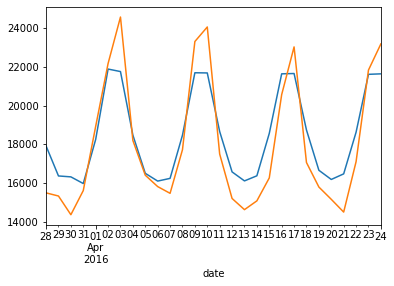

In [168]:
y_pred['CA'].plot()
y_test['CA'].plot()

### ETS

### Prophet

## Exogenous variables